In [54]:
import copy
import random
import itertools
from tabulate import tabulate
import json

def sort_subsublists(lst):
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            lst[i][j].sort()  # Sort each subsublist
    return lst

def setStar(k,m):
    config = []
    central = []
    for chip in range(1,k*m+1):
        central.append(chip)
    for branch in range(k):
        branch_list = []
        for vertex in range(m+2):
            branch_list.append([])
        branch_list[0]=central
        config.append(branch_list)
    return config

def fireCentralSp(og_config,og_chips):
    config = copy.deepcopy(og_config)
    chipsFired = copy.deepcopy(og_chips)
    k = len(config)
    if len(config[0][0]) >= k:
        for chip in chipsFired:
            config[0][0].remove(chip)
        for i in range(k):
            chip = min(chipsFired)
            config[i][1].append(chip)
            chipsFired.remove(chip)
        config = sort_subsublists(config)
        return config
    else:
        return None

def fireBranchSp(og_config,b,v,og_chips):
    config = copy.deepcopy(og_config)
    chipsFired = copy.deepcopy(og_chips)
    if len(config[b][v]) >= 2:
        config[b][v-1].append(min(chipsFired))
        config[b][v+1].append(max(chipsFired))
        config[b][v].remove(min(chipsFired))
        config[b][v].remove(max(chipsFired))
        config = sort_subsublists(config)
        return config
    else:
        return None

def subsets_of_k(nested_list, k):
    all_subsets = []
    
    for sublist in nested_list:
        if len(sublist) >= k:
            subsets = list(itertools.combinations(sublist, k))
            all_subsets.extend(subsets)  # Flatten all combinations into one list
    
    return all_subsets

def all_pairs(lst):
    pairs = []
    for i in range(len(lst)):
        for j in range(i + 1, len(lst)):  # j starts from i + 1 to avoid duplicates
            pairs.append((lst[i], lst[j]))
    return pairs

def all_tuples(lst, k):
    return list(itertools.combinations(lst, k))

def getFirableSp(og_config):
    config = copy.deepcopy(og_config)
    k = len(config)
    l = len(config[0])
    firable = []
    firable_at_zero = all_tuples(config[0][0],k)
    for ktup in firable_at_zero:
        if fireCentralSp(config,list(ktup)) is not None:
            firable.append([0,0,list(ktup)])
    for b in range(k):
        for v in range(1,l):
            firable_on_branch = all_pairs(config[b][v])
            for pair in firable_on_branch:
                if fireBranchSp(config,b,v,list(pair)) is not None:
                    firable.append([b,v,list(pair)])
    return firable

def generate_reachable_configs(config):
    reachableConfigs = [config]  # Start with the original config in the list
    new_configs_found = True
    while new_configs_found:
        new_configs_found = False  # Assume no new configs found unless proven otherwise
        for current_config in reachableConfigs[:]:  # Use a slice to avoid modifying list while iterating
            firable = getFirableSp(current_config)
            for triple in firable:
                if triple[1] == 0:
                    new_config = fireCentralSp(current_config,triple[2])
                    if new_config is not None and new_config not in reachableConfigs:
                        reachableConfigs.append(new_config)
                        new_configs_found = True  # We found a new config, so continue the loop
                else:
                    new_config = fireBranchSp(current_config,triple[0],triple[1],triple[2]) # og_config,b,v,og_chips
                    if new_config is not None and new_config not in reachableConfigs:
                        reachableConfigs.append(new_config)
                        new_configs_found = True  # We found a new config, so continue the loop
    return reachableConfigs

def genEdges(config):
    reachableConfigs = generate_reachable_configs(config)
    numVertices = len(reachableConfigs)
    edges = []
    for i in range(numVertices):
        reached = reachableConfigs[i]
        check_firings = getFirableSp(reached)
        for firable in check_firings:
            if firable[1] == 0:
                firedConfig = fireCentralSp(reached,firable[2])
            else:
                firedConfig = fireBranchSp(reached,firable[0],firable[1],firable[2])
            if firedConfig in reachableConfigs and [i,reachableConfigs.index(firedConfig)] not in edges:
                edges.append([i,reachableConfigs.index(firedConfig)])
            else:
                pass
    return edges

def vertex_prob_label(digraph):
    digraph.set_vertex(0,1)
    levels = len(digraph.longest_path())
    for lvl in range(1,levels):
        lvl_vertices = [v for v in digraph.vertices() if digraph.shortest_path_length(0,v) == lvl]
        for v in lvl_vertices:
            new_label = sum([digraph.get_vertex(n)/digraph.out_degree(n) for n in digraph.neighbors_in(v)])
            digraph.set_vertex(v,new_label)
        level_sum = sum([digraph.get_vertex(v) for v in lvl_vertices])
        if level_sum == 1:
            pass
        else:
            print(f"level {lvl} has an error: probabilities sum to {level_sum}")
    return digraph

In [57]:
def optionsTestStar(k,m,print_poset,print_all_or_terminal,print_probabilities,print_paths,print_levels,table_format):
    # checking input validity
    if not (k > 0 and k.is_integer()):
        print(f"k should be a positive integer")
        return None
    if not (m > 0 and m.is_integer()):
        print(f"m should be a positive integer")
        return None
    TFList = [True,False]
    if print_poset not in TFList or print_probabilities not in TFList or print_paths not in TFList or print_levels not in TFList:
        print(f"print_poset, print_probabilities, print_paths, and print_levels should all be either True or False (without quotation marks)")
        return None
    if print_all_or_terminal not in ['all', 'terminal', 'none']:
        print(f"choose print_all_or_terminal to be 'all' or 'terminal' or 'none' (with quotations) instead of {print_all_or_terminal}")
        return None
    if table_format not in ['outline', 'latex', 'github']:
        print(f"table_format should be either 'outline' or 'latex' or 'github' (with quotations)")
        return None

    # setup
    print(f"testing (k,m)=({k},{m})")
    config = setStar(k,m)
    reachables = generate_reachable_configs(config)
    edges = genEdges(config)
    digraph = DiGraph(edges)
    poset = Poset(digraph)

    # print_poset
    if print_poset == True:
        poset.show()
        print(" ")
    
    rnk = poset.rank()
    Lkm = len(poset.maximal_chains())
    max_elts = poset.maximal_elements()
    print(f"rank: {rnk}")
    print(f"unique terminal configurations: {len(max_elts)}")
    print(f"L({k},{m}) = {Lkm}")
    
    elements_to_print = []
    # print_all_or_terminal
    if print_all_or_terminal == 'all':
        for elt in poset:
            elements_to_print.append(elt)
    elif print_all_or_terminal == 'terminal':
        elements_to_print = max_elts
    else:
        return None

    table = []
    heading = {
        'index': 'index',
        'name': 'element',
    }

    for elt_index in elements_to_print:
        dictionary = {}
        dictionary['index'] = elt_index
        dictionary['name'] = reachables[elt_index]
        table.append(copy.deepcopy(dictionary))

    # print_probabilities
    if print_probabilities == True:
        heading['probability'] = 'probability'
        labeled_digraph = vertex_prob_label(digraph)
        for v in digraph.vertices():
            for dictionary in table:
                if dictionary['index'] == v:
                    dictionary['probability'] = digraph.get_vertex(v)

    # print_PQ
    if print_all_or_terminal == 'terminal' and print_paths == True:
        heading['paths'] = 'paths to configuration'
        for dictionary in table:
            dictionary['paths'] = 0
        for chain in poset.maximal_chains():
            for dictionary in table:
                if chain[rnk] == dictionary['index']:
                    dictionary['paths'] += 1

    # print_levels
    if print_all_or_terminal == 'all' and print_levels == True:
        heading['level'] = 'level'
        for vertex in table:
            vertex['level'] = digraph.shortest_path_length(0,vertex['index'])
    
    # sort table by index
    table.sort(key=lambda x: x['index'])
    print(tabulate(table, headers=heading, tablefmt=table_format))
    print(" ")
    
    return None

"""
USAGE

k (positive integer)
    number of branches
    
m (positive integer)
    n=km is the total number of chips
    
print_poset (True OR False)

print_all_or_terminal ('all' OR 'terminal' OR 'none')
    'all' prints a table of all reachable configurations
    'terminal' prints only stable configurations
    'none' only prints the rank, the number of unique terminal configurations, and L(k,m)
    
print_probabilities (True OR False)
    prints the probability of each vertex being reached
    
print_paths (True OR False)
    prints the number of paths to a specific vertex
    only works if print_all_or_terminal == 'terminal'
    
print_levels (True OR False)
    prints the "level" of any element in the poset (initial being 0, terminals being the rank of the poset)
    only works if print_all_or_terminal == 'all'
    
table_format ('outline' OR 'latex' OR 'github')
    'outline' prints the output in a readable table
    'latex' prints it in a LaTeX table format for copy & pasting
    'github' is nice for copy & pasting into Google Sheets and separating data to columns
"""

print("ready to go!")

ready to go!


testing (k,m)=(2,2)


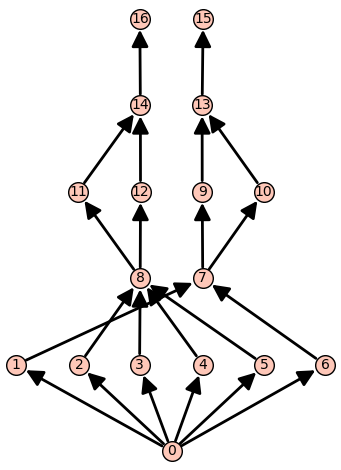

 
rank: 5
unique terminal configurations: 2
L(2,2) = 12
+---------+----------------------------------------------------------+---------------+---------+
|   index | element                                                  |   probability |   level |
+=========+==========================================================+===============+=========+
|       0 | [[[1, 2, 3, 4], [], [], []], [[1, 2, 3, 4], [], [], []]] |      1        |       0 |
|       1 | [[[3, 4], [1], [], []], [[3, 4], [2], [], []]]           |      0.166667 |       1 |
|       2 | [[[2, 4], [1], [], []], [[2, 4], [3], [], []]]           |      0.166667 |       1 |
|       3 | [[[2, 3], [1], [], []], [[2, 3], [4], [], []]]           |      0.166667 |       1 |
|       4 | [[[1, 4], [2], [], []], [[1, 4], [3], [], []]]           |      0.166667 |       1 |
|       5 | [[[1, 3], [2], [], []], [[1, 3], [4], [], []]]           |      0.166667 |       1 |
|       6 | [[[1, 2], [3], [], []], [[1, 2], [4], [], []]]           | 

In [59]:
# test

k=2
m=2
print_poset = True
print_all_or_terminal = 'all'
print_probabilities = True
print_paths = True
print_levels = True
table_format = 'outline'

optionsTestStar(k,m,print_poset,print_all_or_terminal,print_probabilities,print_paths,print_levels,table_format)